In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
import pickle as pkl
import time

In [2]:
 def create_lstm_dataset(time_series:pd.Series, lookback:int):
    """
        Transform a time series into a prediction dataset
        Input:
            time_series: A numpy array of time series, first dimension is the time steps
            lookback: Integer, Size of window for prediction
        Output:
            torch tensor(X) and torch tensor(Y) objects
    """
    X, y = [], []
    for i in range(len(time_series)-lookback):
        feature = time_series[i:i+lookback]
        target = time_series[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [3]:
class AirModel(nn.Module, lookback:int=48):
    """
        This a calss handle the LSTM model
        Input:
            pytorch Module
        Output:
            torch tensor(X) and torch tensor(Y) objects
    """    
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=lookback, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, lookback)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

# LSTM Parameters

In [4]:
lookback = 48
n_epochs = 200

# Load Data for Model training

In [5]:
data_df = pd.read_csv("../Data/pre_processed_final_data.csv")
data_df['date_time'] = pd.to_datetime(data_df['date_time'], infer_datetime_format=True, dayfirst=False)
data_df.set_index('date_time', inplace=True)

In [6]:
ts = data_df['System Sell Price(GBP/MWh)'].values.astype('float32')

# Split the training and test dataset

In [7]:
train_size = data_df[:'2022-12-31'].shape[0]
test_size  = data_df['2023-01-01':].shape[0]
train = ts[:train_size]
test = ts[train_size:]


In [8]:
X_train, y_train = create_lstm_dataset(train, lookback=lookback)
X_test, y_test = create_lstm_dataset(test, lookback=lookback)
print("Trainning dataset size", X_train.shape, y_train.shape)
print("Test dataset size", X_test.shape, y_test.shape)

Trainning dataset size torch.Size([70080, 48]) torch.Size([70080, 48])
Test dataset size torch.Size([9792, 48]) torch.Size([9792, 48])


/var/folders/94/prhb7cd55j501j6_x3p5llmw0000gn/T/ipykernel_4458/540755606.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_82vavna4yl/croot/pytorch_1686931843901/work/torch/csrc/utils/tensor_new.cpp:248.)
  return torch.tensor(X), torch.tensor(y)


# Create LSTM Model

In [9]:
model = AirModel(lookback)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

# Train LSTM Model

In [10]:
start_time = time.time()
for epoch in range(n_epochs):
    
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 10 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
        end_time = time.time()
        elapsed_time = end_time - start_time
        start_time = end_time
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f Cpu Time %.4f" % (epoch, train_rmse, test_rmse, elapsed_time))

Epoch 0: train RMSE 106.5613, test RMSE 60.6234 Cpu Time 18.8950
Epoch 10: train RMSE 88.8057, test RMSE 54.3064 Cpu Time 210.8188
Epoch 20: train RMSE 85.2178, test RMSE 51.5216 Cpu Time 214.8337
Epoch 30: train RMSE 85.5440, test RMSE 50.5694 Cpu Time 241.7534
Epoch 40: train RMSE 85.3499, test RMSE 53.1587 Cpu Time 236.5740
Epoch 50: train RMSE 86.1833, test RMSE 51.8022 Cpu Time 243.5330
Epoch 60: train RMSE 83.9912, test RMSE 52.8471 Cpu Time 253.7642
Epoch 70: train RMSE 87.2119, test RMSE 56.3253 Cpu Time 240.9190
Epoch 80: train RMSE 82.8591, test RMSE 52.2928 Cpu Time 222.9379
Epoch 90: train RMSE 83.3570, test RMSE 55.5054 Cpu Time 226.4048
Epoch 100: train RMSE 83.4518, test RMSE 51.9892 Cpu Time 228.8483
Epoch 110: train RMSE 84.0689, test RMSE 55.9867 Cpu Time 227.3814
Epoch 120: train RMSE 82.7421, test RMSE 54.6576 Cpu Time 259.6184
Epoch 130: train RMSE 83.9816, test RMSE 56.3286 Cpu Time 3671.7618
Epoch 140: train RMSE 82.0967, test RMSE 54.4354 Cpu Time 244.9310
Epoch

# Plot LSTM Prediction

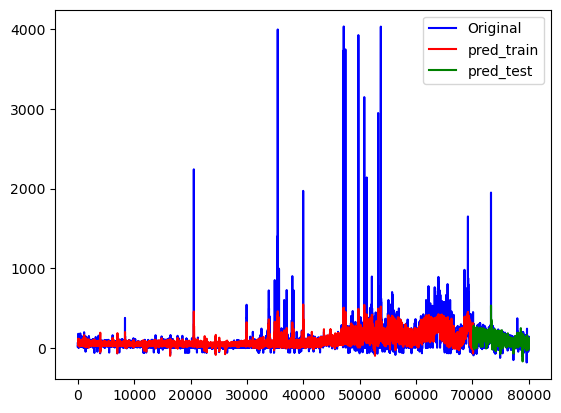

<Figure size 640x480 with 0 Axes>

In [11]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(ts) * np.nan
    train_pred = model(X_train)[:, -1 :].flatten()
    test_pred  = model(X_test)[:, -1 :].flatten()
    train_plot[lookback:train_size] = train_pred
    # shift test predictions for plotting
    test_plot = np.ones_like(ts) * np.nan
    test_plot[train_size+lookback:len(ts)] = test_pred

# plot
plt.plot(ts, c='b',label='Original')
plt.plot(train_plot, c='r',label='pred_train')
plt.plot(test_plot, c='g', label='pred_test')
plt.legend(loc='best')
# plt.show()
plt.savefig("../Output/LSTM_pred.png")

# Save LSTM Model

In [12]:
with open("../Models/LSTM_model.pkl", mode='wb') as file:
    pkl.dump(model, file)
    file.close()

# Calculate MSE & R Square

In [14]:
mse = mean_squared_error(test_pred, test[:-lookback]) 
r2 = r2_score(test_pred, test[:-lookback])
print("MSE", mse)
print("R2", r2)

MSE 4687.809
R2 -0.9026425448194235
